In [6]:
import os
import shutil

import matplotlib.pyplot as plt

from dummy_baskets import generate_dummy_baskets, run_index_basket_upload_test 
from weave.index.index_pandas import IndexPandas
from weave.index.index_sqlite import IndexSQLite
from weave.index.index_sql import IndexSQL

import multiprocessing
from fsspec.implementations.local import LocalFileSystem
from weave.pantry import Pantry

**Pandas Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In these tests we will be analyzing the performance differences when more files are uploaded, files are larger, and the number of basket types are increased. This will done using the pandas index.

In [ ]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
pandas_time1 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {pandas_time1} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

In [ ]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
pandas_time2 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 10 upload files, 1 mb size files, 1 basket type: {pandas_time2} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Performance difference between uploading 10 files in each basket compared to 1 file in each basket

In [ ]:
categories = ["10 Files", "1 File"]
values = [pandas_time2, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Upload Files')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 10 Files and 1 File')

plt.show()


As you can see there is almost no difference in performance when we upload multiple files in each basket compared to one file

In [ ]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=2, file_path="dummy_txt", num_basket_types=1)
pandas_time3 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 2 mb size files, 1 basket type: {pandas_time3} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Performance difference between uploading a 2 mb file in each basket compared to a 1 mb file in each basket

In [ ]:
categories = ["2 MB", "1 MB"]
values = [pandas_time3, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Size of File (MB)')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 2 MB and 1 MB files')

plt.show()

Once again, there is almost no performance difference between uploading a 2 MB file and a 1 MB file in each basket

In [ ]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=10)
pandas_time4 = run_index_basket_upload_test(basket_list=baskets, index=IndexPandas, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 10 basket types: {pandas_time4} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

Performance difference between uploading 10 basket types versus 1 basket types

In [ ]:
categories = ["10", "1"]
values = [pandas_time4, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Basket Types')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 10 and 1 Basket Types')

Once again, there seems to be no performance difference between number of basket types

**SQLite Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In this test we will test the performance of uploading baskets using the same parameters as the first index pandas test. We will be using the SQLite index backend for these tests.

In [ ]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
sqlite_time1 = run_index_basket_upload_test(basket_list=baskets, index=IndexSQLite, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {sqlite_time1} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")
os.remove("dummy_pantry.db")


Performance difference between the Pandas Index and the SQLite index

In [ ]:
categories = ["Pandas Index", "SQLite Index"]
values = [pandas_time1, sqlite_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Performance Difference Between Pandas and SQLite Indexes')

From the graph we can see there is a huge performance difference between the pandas and sqlite indexes

**SQL Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In this test we will test the performance of uploading baskets using the same parameters as the first index pandas test and the first index sqlite test. We will be using the SQL index backend for these tests.

Please make sure to connect your SQL server and the proper environment variables are in place to run these tests. 

In [7]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
sql_time2 = run_index_basket_upload_test(basket_list=baskets, index=IndexSQL, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {sql_time2} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

file_system = LocalFileSystem()
index_obj = IndexSQL(pantry_path="dummy_pantry", file_system=file_system)
index_obj.drop_index()

Time taken to upload 1000 baskets: 21.262235641479492 seconds.
1000 baskets, 1 upload file, 1 mb size files, 1 basket type: 21.262235641479492 seconds


Performance difference between the Pandas Index, the SQLite Index and the SQL Index.

In [ ]:
categories = ["Pandas Index", "SQLite Index", "SQL Index"]
values = [pandas_time1, sqlite_time1, sql_time2]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Performance Difference Between Pandas, SQLite and SQL Indexes')

Looking at the graph, we can see that the difference between the Pandas Index and the other indexes is quite large. While, the difference between the SQLite Index and the SQL index is a bit smaller. 

**SQL Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type, 5 Processes)**

In this test we will test the performance of uploading baskets using 5 processes each with 200 baskets. This will simulate 5 different users attempting to upload to the index at the same time. We will be using the SQL index backend for these tests.

Please make sure to connect your SQL server and the proper environment variables are in place to run these tests. 

In [16]:
# SQL Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type, 5 Processes)
# In this test we will test the performance of uploading baskets using 5 processes each with 200 baskets.
# This will simulate 5 different users attempting to upload to the index at the same time.

def _upload_baskets_worker(baskets, index, pantry_path, file_system, worker_id=None):
    pantry = Pantry(index, pantry_path=pantry_path, file_system=file_system)
    for basket in baskets:
        pantry.upload_basket(**basket)

def run_index_basket_upload_test_five(basket_list, index, pantry_path="dummy_pantry", **kwargs):
    from fsspec.implementations.local import LocalFileSystem
    import time

    file_system = kwargs.get("file_system", LocalFileSystem())
    num_basket_uploads = kwargs.get("num_basket_uploads", len(basket_list))

    # Split baskets into 5 chunks
    chunk_size = num_basket_uploads // 5
    basket_chunks = [basket_list[i*chunk_size:(i+1)*chunk_size] for i in range(5)]

    start_time = time.time()

    processes = []
    for i in range(5):
        p = multiprocessing.Process(
            target=_upload_baskets_worker,
            args=(basket_chunks[i], index, pantry_path, file_system, i+1)  # worker_id = i+1
        )
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        print(f"Process {p.pid} finished uploading {len(basket_chunks[i])} baskets.")

    end_time = time.time()
    total_upload_time = end_time - start_time
    print(f"Time taken to upload {num_basket_uploads} baskets with 5 processes: {total_upload_time} seconds.")

    return total_upload_time

# Usage:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
sql_time_five = run_index_basket_upload_test_five(basket_list=baskets, index=IndexSQL, pantry_path="dummy_pantry")
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type (5 processes): {sql_time_five} seconds")
shutil.rmtree("dummy_txt")

file_system = LocalFileSystem()
index_obj = IndexSQL(pantry_path="dummy_pantry", file_system=file_system)
index_obj.drop_index()

Process 2308 finished uploading 200 baskets.
Process 18896 finished uploading 200 baskets.
Process 11716 finished uploading 200 baskets.
Process 18544 finished uploading 200 baskets.
Process 4320 finished uploading 200 baskets.
Time taken to upload 1000 baskets with 5 processes: 0.2292344570159912 seconds.
1000 baskets, 1 upload file, 1 mb size files, 1 basket type (5 processes): 0.2292344570159912 seconds


Comparing 5 processes to the SQL Index test using 1 process.

Text(0.5, 1.0, 'Performance Difference Between 1 process and 5 processes for SQL Index')

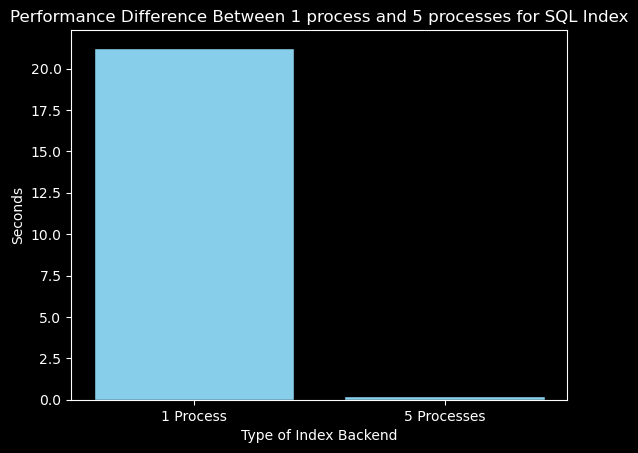

In [17]:
categories = ["1 Process", "5 Processes"]
values = [sql_time2, sql_time_five]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 1 process and 5 processes for SQL Index')